In [10]:
#%% 
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy.stats import norm
from xarray_einstats.stats import XrContinuousRV

#Comment: This notebook is based on/follows the structure of https://www.pymc.io/projects/examples/en/2021.11.0/mixture_models/gaussian_mixture_model.html

In [57]:
dataframe = pd.read_csv(
    "/Users/sydney/git/twitter-study/AnalysisSP/work_reduced_2020.csv", index_col = 0
)
data = dataframe["value"].to_xarray()

/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/pymc/distributions/transforms.py:56: FutureWarning: univariate_ordered has been deprecated, use ordered instead.
  warnings.warn(f"{name} has been deprecated, use ordered instead.", FutureWarning)


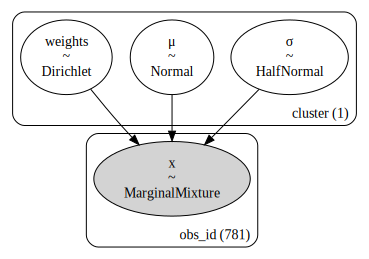

In [64]:
k = 1

with pm.Model(coords={"cluster": range(k), "obs_id": np.arange(781)}) as model:
    μ = pm.Normal(
        "μ",
        mu=[-50],
        sigma=1,
        transform=pm.distributions.transforms.univariate_ordered,
        #initval=[-45],
        dims="cluster",
    )
    σ = pm.HalfNormal("σ", sigma=[0.2], dims="cluster")
    weights = pm.Dirichlet("weights", np.ones(k), dims="cluster")
    pm.NormalMixture("x", w=weights, mu=μ, sigma=σ, observed=data, dims = "obs_id")

pm.model_to_graphviz(model)

In [68]:
with model:
    trace = pm.sample(5000, n_init=1000, tune=5000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

    # sample posterior predictive samples
    ppc_trace = pm.sample_posterior_predictive(trace, var_names=["μ", "σ", "weights"])


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, weights]


/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 4 seconds.
/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
Sampling: [weights, μ, σ]


/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

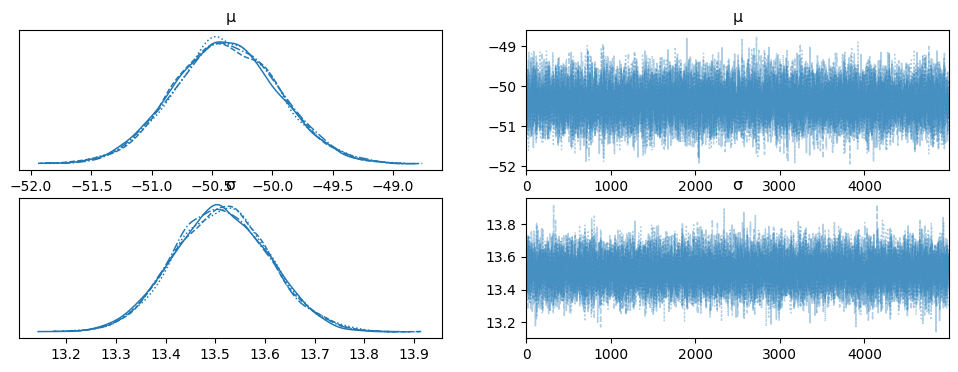

In [70]:
az.plot_trace(trace, var_names=["μ", "σ"]);

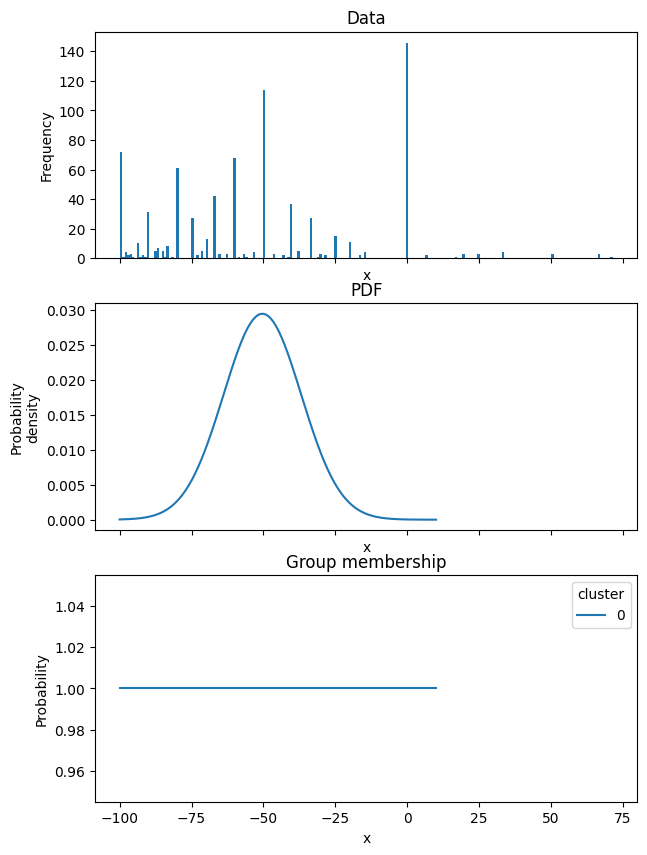

In [71]:
xi = np.linspace(-100, 10, 500)
post = trace.posterior
pdf_components = XrContinuousRV(norm, post["μ"], post["σ"]).pdf(xi) * post["weights"]
pdf = pdf_components.sum("cluster")

fig, ax = plt.subplots(3, 1, figsize=(7, 10), sharex=True)
# empirical histogram
ax[0].hist(data, 200)
ax[0].set(title="Data", xlabel="x", ylabel="Frequency")
# pdf
pdf_components.mean(dim=["chain", "draw"]).sum("cluster").plot.line(ax=ax[1])
ax[1].set(title="PDF", xlabel="x", ylabel="Probability\ndensity")
# plot group membership probabilities
(pdf_components / pdf).mean(dim=["chain", "draw"]).plot.line(hue="cluster", ax=ax[2])
ax[2].set(title="Group membership", xlabel="x", ylabel="Probability");

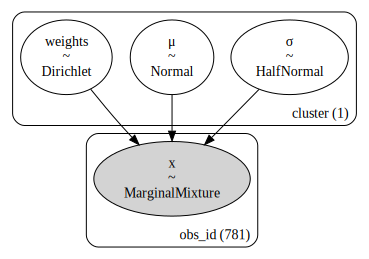

In [74]:
k = 2

with pm.Model(coords={"cluster": np.arange(k), "obs_id": np.arange(781)}) as model_2:
    #cluster sizes
    weights = pm.Dirichlet("weights", a=np.array([1.0, 0.5]), dims="cluster")
    #ensure all clusters have some points
    p_min_potential = pm.Potential("p_min_potential", pm.math.switch(pm.math.min(weights) < 0.1, -np.inf, 0))
    #cluster means
    μ = pm.Normal(
        "μ",
        mu=[-50,0],
        sigma=1,
        #transform=pm.distributions.transforms.univariate_ordered,
        #initval=[-100,0],
        dims="cluster",
    )
    #break symmetry 
    order_means_potential = pm.Potential(
        "order_means_potential",
        pm.math.switch(μ[1] - μ[0] < 0, -np.inf, 0)
    )
    #measurement error
    σ  = pm.Uniform("σ", lower=0, upper=20)
    
    #latent cluster of each observation
    category = pm.Categorical("category", p = weights, dims = "obs_id")
    
    #likelihood for each observed value
    points = pm.Normal("obs", mu=μ[category], sigma=σ, observed=data, dims="obs_id")
    #pm.NormalMixture("x", w=weights, mu=μ, sigma=σ, observed=data, dims = "obs_id")

pm.model_to_graphviz(model)

In [75]:
with model_2:
    step1 = pm.Metropolis(vars=[weights, μ, σ])
    step2 = pm.CategoricalGibbsMetropolis(vars=[category])
    trace2 = pm.sample(20000, step=[step1, step2], tune=5000, return_inferencedata=True,idata_kwargs={"log_likelihood": True})
    # sample posterior predictive samples
    ppc_trace_2 = pm.sample_posterior_predictive(trace2, var_names=["weights", "μ", "σ"])
    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [weights]
>>Metropolis: [μ]
>>Metropolis: [σ]
>CategoricalGibbsMetropolis: [category]


/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:318: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:318: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:318: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 20_000 draw iterations (20_000 + 80_000 draws total) took 1024 seconds.
/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/var/folders/7x/6jsnktzj2z3fg3rq6l15mfdw0000gn/T/ipykernel_15069/2254677301.py:6: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc_trace_2 = pm.sample_posterior_predictive(trace2, var_names=["weights", "μ", "σ"])
Sampling: [weights, μ, σ]


/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

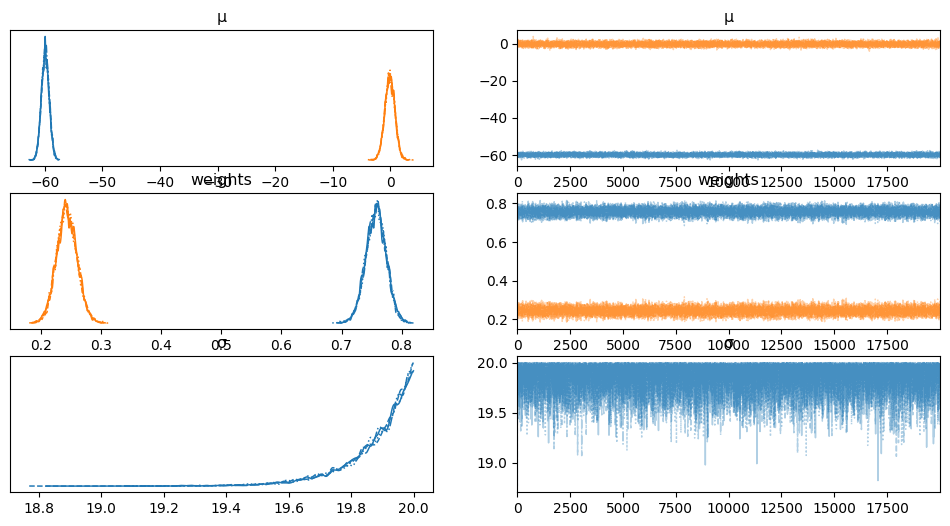

In [39]:
az.plot_trace(trace2, var_names=["μ", "weights", "σ"]);

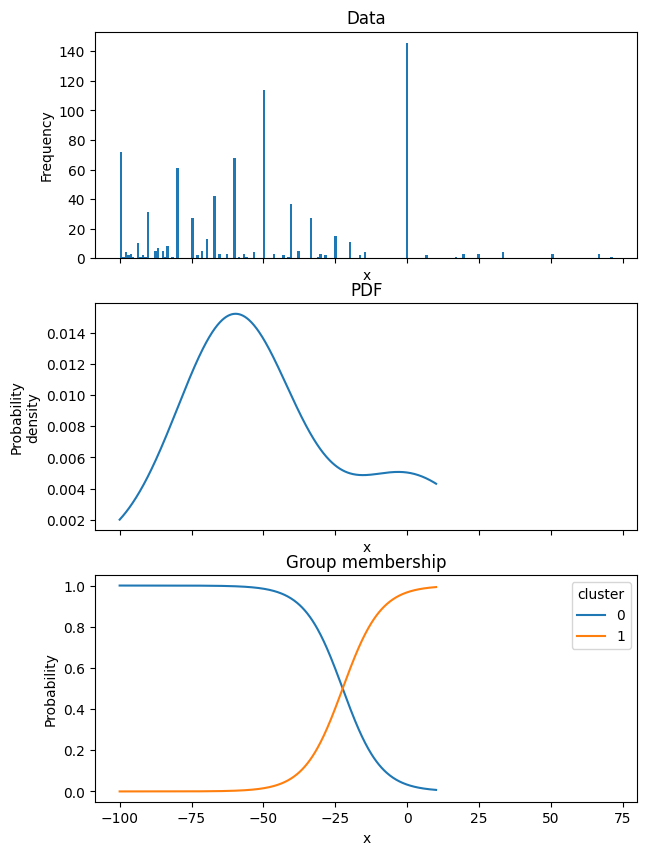

In [40]:
xi = np.linspace(-100, 10, 500)
post = trace2.posterior
pdf_components = XrContinuousRV(norm, post["μ"], post["σ"]).pdf(xi) * post["weights"]
pdf = pdf_components.sum("cluster")

fig, ax = plt.subplots(3, 1, figsize=(7, 10), sharex=True)
# empirical histogram
ax[0].hist(data, 200)
ax[0].set(title="Data", xlabel="x", ylabel="Frequency")
# pdf
pdf_components.mean(dim=["chain", "draw"]).sum("cluster").plot.line(ax=ax[1])
ax[1].set(title="PDF", xlabel="x", ylabel="Probability\ndensity")
# plot group membership probabilities
(pdf_components / pdf).mean(dim=["chain", "draw"]).plot.line(hue="cluster", ax=ax[2])
ax[2].set(title="Group membership", xlabel="x", ylabel="Probability");

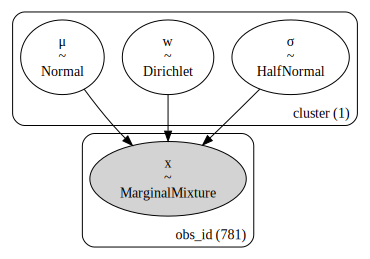

In [45]:
k = 3

with pm.Model(coords={"cluster": np.arange(k), "obs_id": np.arange(781)}) as model_3:
    #cluster sizes
    weights = pm.Dirichlet("weights", a=np.array([0.5, 1.0, 0.5]), dims="cluster")
    #ensure all clusters have some points
    p_min_potential = pm.Potential("p_min_potential", pm.math.switch(pm.math.min(weights) < 0.1, -np.inf, 0))
    #cluster means
    μ = pm.Normal(
        "μ",
        mu=[-100,-50,0],
        sigma=1,
        #transform=pm.distributions.transforms.univariate_ordered,
        #initval=[-100,0],
        dims="cluster",
    )
    #break symmetry 
    order_means_potential = pm.Potential(
        "order_means_potential",
        pm.math.switch(μ[1] - μ[0] < 0, -np.inf, 0) + pm.math.switch(μ[2] - μ[1] < 0, -np.inf, 0)
    )
    #measurement error
    σ  = pm.Uniform("σ", lower=0, upper=20)
    
    #latent cluster of each observation
    category = pm.Categorical("category", p = weights, dims = "obs_id")
    
    #likelihood for each observed value
    points = pm.Normal("obs", mu=μ[category], sigma=σ, observed=data, dims="obs_id")
    #pm.NormalMixture("x", w=weights, mu=μ, sigma=σ, observed=data, dims = "obs_id")

pm.model_to_graphviz(model)

In [46]:
with model_3:
    step1 = pm.Metropolis(vars=[weights, μ, σ])
    step2 = pm.CategoricalGibbsMetropolis(vars=[category])
    trace3 = pm.sample(20000, step=[step1, step2], tune=5000, return_inferencedata=True)
    # sample posterior predictive samples
    ppc_trace_4 = pm.sample_posterior_predictive(trace3, var_names=["weights", "μ", "σ"])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [weights]
>>Metropolis: [μ]
>>Metropolis: [σ]
>CategoricalGibbsMetropolis: [category]


/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:318: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:318: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 20_000 draw iterations (20_000 + 80_000 draws total) took 1061 seconds.
/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/var/folders/7x/6jsnktzj2z3fg3rq6l15mfdw0000gn/T/ipykernel_15069/399194479.py:6: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc_trace_4 = pm.sample_posterior_predictive(trace3, var_names=["weights", "μ", "σ"])
Sampling: [weights, μ, σ]


/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

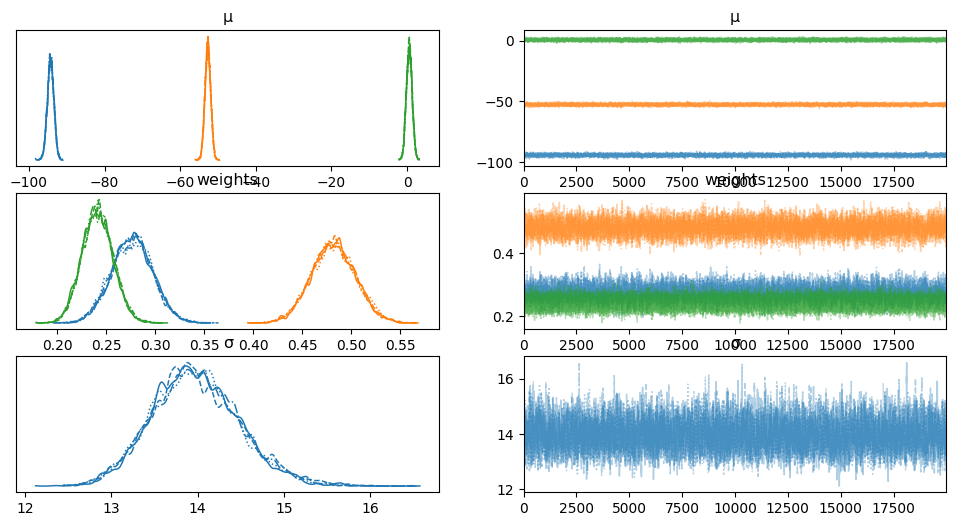

In [49]:
az.plot_trace(trace3, var_names=["μ", "weights", "σ"]);

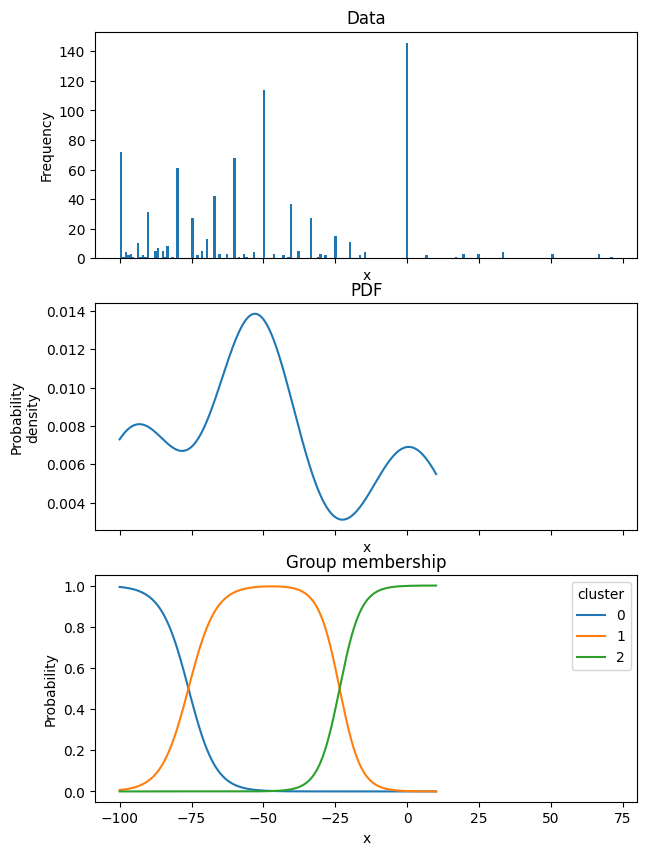

In [48]:
xi = np.linspace(-100, 10, 500)
post = trace3.posterior
pdf_components = XrContinuousRV(norm, post["μ"], post["σ"]).pdf(xi) * post["weights"]
pdf = pdf_components.sum("cluster")

fig, ax = plt.subplots(3, 1, figsize=(7, 10), sharex=True)
# empirical histogram
ax[0].hist(data, 200)
ax[0].set(title="Data", xlabel="x", ylabel="Frequency")
# pdf
pdf_components.mean(dim=["chain", "draw"]).sum("cluster").plot.line(ax=ax[1])
ax[1].set(title="PDF", xlabel="x", ylabel="Probability\ndensity")
# plot group membership probabilities
(pdf_components / pdf).mean(dim=["chain", "draw"]).plot.line(hue="cluster", ax=ax[2])
ax[2].set(title="Group membership", xlabel="x", ylabel="Probability");

In [72]:
df_comp_loo = az.compare({"one_dist": trace, "two_dist": trace2, "three_dist":trace3})
df_comp_loo

TypeError: Encountered error in ELPD computation of compare.

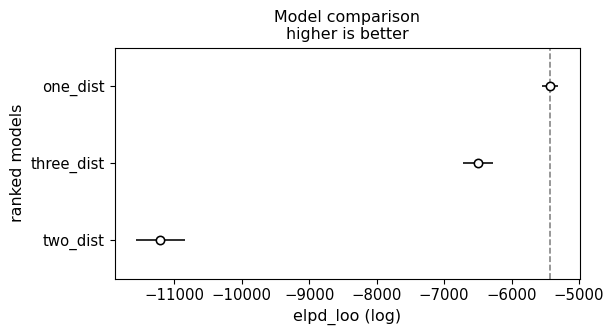

In [128]:
az.plot_compare(df_comp_loo, insample_dev=False);